# Predict whether teachers' project proposals are accepted

Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible

How to increase the consistency of project vetting across different volunteers to improve the experience for teachers

How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

With an algorithm to pre-screen applications, DonorsChoose.org can auto-approve some applications quickly so that volunteers can spend their time on more nuanced and detailed project ​vetting processes, including doing more to help teachers develop projects that qualify for specific funding opportunities.

Your machine learning algorithm can help more teachers get funded more quickly, and with less cost to DonorsChoose.org, allowing them to channel even more funding directly to classrooms across the country.

## 1.1 Loading Data

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')

In [3]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
data.shape

(109248, 9)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 9 columns):
school_state                                    109248 non-null object
teacher_prefix                                  109248 non-null object
project_grade_category                          109248 non-null object
teacher_number_of_previously_posted_projects    109248 non-null int64
project_is_approved                             109248 non-null int64
clean_categories                                109248 non-null object
clean_subcategories                             109248 non-null object
essay                                           109248 non-null object
price                                           109248 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 7.5+ MB


In [6]:
data.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,price
count,109248.000000,109248.000000,109248.000000
mean,11.153165,0.848583,298.119343
std,27.777154,0.358456,367.498030
min,0.000000,0.000000,0.660000
25%,0.000000,1.000000,104.310000
50%,2.000000,1.000000,206.220000
75%,9.000000,1.000000,379.000000
max,451.000000,1.000000,9999.000000


In [7]:
data.project_is_approved.value_counts(normalize=True)

1    0.848583
0    0.151417
Name: project_is_approved, dtype: float64

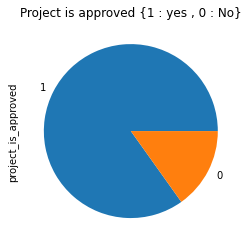

In [8]:
data.project_is_approved.value_counts(normalize=True).plot.pie()
plt.title("Project is approved {1 : yes , 0 : No}")
plt.show()

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [10]:
y = data["project_is_approved"].values
X = data.drop(["project_is_approved"], axis = 1)

In [11]:
# train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

## TFIDF vectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = vectorizer1.fit_transform(X_train['essay'].values)

print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (53531, 5000)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer1.fit_transform(X_train['essay'].values)
essay_features = vectorizer1.get_feature_names()
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (53531, 12554)


In [15]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
feature_names_tfidf = []
vectorizer2 = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = vectorizer2.fit_transform(X_train['essay'].values)


# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer2.fit_transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer2.fit_transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer2.fit_transform(X_test['essay'].values)
print(" ")
print("="*100)
print("\nAfter vectorizations\n")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)


(53531, 8) (53531,)
(22942, 8) (22942,)
(32775, 8) (32775,)
 

After vectorizations

(53531, 5000) (53531,)
(22942, 5000) (22942,)
(32775, 5000) (32775,)


## TFIDF weighted W2V

In [16]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8", errors='ignore')
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model


In [17]:
model = loadGloveModel('glove.42B.300d.txt')

Loading Glove Model


1917494it [04:06, 7770.51it/s]


Done. 1917494  words loaded!


In [18]:
glove_words =  set(model.keys())

In [19]:
preprocessed_essays = X_train['essay'].values

In [20]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [21]:
def tfidf_w2v(essay):
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(essay): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    return tfidf_w2v_vectors

In [22]:
tfidf_w2v_vectors_train = tfidf_w2v(X_train['essay'].values)

100%|███████████████████████████████████████████████████████████████████████████| 53531/53531 [01:36<00:00, 557.50it/s]


53531
300


In [23]:
tfidf_w2v_vectors_test = tfidf_w2v(X_test['essay'].values)

100%|███████████████████████████████████████████████████████████████████████████| 32775/32775 [01:05<00:00, 502.34it/s]


32775
300


In [24]:
tfidf_w2v_vectors_cv = tfidf_w2v(X_cv['essay'].values)

100%|███████████████████████████████████████████████████████████████████████████| 22942/22942 [00:40<00:00, 569.14it/s]


22942
300


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

## categorical features

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
vectorizer_state = CountVectorizer()
vectorizer_state.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_state.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer_state.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer_state.transform(X_test['school_state'].values)

state_feature = vectorizer_state.get_feature_names()

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(state_feature)
print("="*100)

After vectorizations
(53531, 51) (53531,)
(22942, 51) (22942,)
(32775, 51) (32775,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [27]:
vectorizer_teacher = CountVectorizer()
vectorizer_teacher.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer_teacher.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_teacher.transform(X_test['teacher_prefix'].values)

teacher_feature = vectorizer_teacher.get_feature_names()

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(teacher_feature)
print("="*100)

After vectorizations
(53531, 5) (53531,)
(22942, 5) (22942,)
(32775, 5) (32775,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [28]:
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer_grade.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer_grade.transform(X_test['project_grade_category'].values)

grade_feature = vectorizer_grade.get_feature_names()

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(grade_feature)
print("="*100)

After vectorizations
(53531, 4) (53531,)
(22942, 4) (22942,)
(32775, 4) (32775,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [29]:
vectorizer_subcat = CountVectorizer()
vectorizer_subcat.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat_ohe = vectorizer_subcat.transform(X_train['clean_subcategories'].values)
X_cv_subcat_ohe = vectorizer_subcat.transform(X_cv['clean_subcategories'].values)
X_test_subcat_ohe = vectorizer_subcat.transform(X_test['clean_subcategories'].values)

subcat_feature = vectorizer_subcat.get_feature_names()

print("After vectorizations")
print(X_train_subcat_ohe.shape, y_train.shape)
print(X_cv_subcat_ohe.shape, y_cv.shape)
print(X_test_subcat_ohe.shape, y_test.shape)
print(subcat_feature)
print("="*100)

After vectorizations
(53531, 30) (53531,)
(22942, 30) (22942,)
(32775, 30) (32775,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [30]:
vectorizer_cat = CountVectorizer()
vectorizer_cat.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat_ohe = vectorizer_cat.transform(X_train['clean_categories'].values)
X_cv_cat_ohe = vectorizer_cat.transform(X_cv['clean_categories'].values)
X_test_cat_ohe = vectorizer_cat.transform(X_test['clean_categories'].values)

cat_feature = vectorizer_cat.get_feature_names()

print("After vectorizations")
print(X_train_cat_ohe.shape, y_train.shape)
print(X_cv_cat_ohe.shape, y_cv.shape)
print(X_test_cat_ohe.shape, y_test.shape)
print(cat_feature)
print("="*100)

After vectorizations
(53531, 9) (53531,)
(22942, 9) (22942,)
(32775, 9) (32775,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


## Numerical features

In [31]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(53531, 1) (53531,)
(22942, 1) (22942,)
(32775, 1) (32775,)


In [32]:
from sklearn.preprocessing import Normalizer
normalizer1 = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer1.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prev_post = normalizer1.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_prev_post= normalizer1.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prev_post = normalizer1.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_prev_post.shape, y_train.shape)
print(X_cv_prev_post.shape, y_cv.shape)
print(X_test_prev_post.shape, y_test.shape)
print("="*100)

After vectorizations
(53531, 1) (53531,)
(22942, 1) (22942,)
(32775, 1) (32775,)


## <font color='red'>Set 1</font> : categorical, numerical features +  preprocessed_eassay (TFIDF)

In [33]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_1 = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_subcat_ohe,X_train_cat_ohe, X_train_price_norm, X_train_prev_post)).tocsr()
X_cr_1 = hstack((X_cv_essay_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_subcat_ohe,X_cv_cat_ohe, X_cv_price_norm,X_cv_prev_post)).tocsr()
X_te_1 = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_subcat_ohe,X_test_cat_ohe, X_test_price_norm,X_test_prev_post)).tocsr()

print("Final Data matrix")
print(X_tr_1.shape, y_train.shape)
print(X_cr_1.shape, y_cv.shape)
print(X_te_1.shape, y_test.shape)
print("="*100)

Final Data matrix
(53531, 5101) (53531,)
(22942, 5101) (22942,)
(32775, 5101) (32775,)


## <font color='red'>Set 2</font> : categorical, numerical features +  preprocessed_eassay (TFIDF W2V)

In [34]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_2 = hstack((tfidf_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_subcat_ohe,X_train_cat_ohe, X_train_price_norm, X_train_prev_post)).tocsr()
X_cr_2 = hstack((tfidf_w2v_vectors_cv, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe,X_cv_subcat_ohe,X_cv_cat_ohe, X_cv_price_norm,X_cv_prev_post)).tocsr()
X_te_2 = hstack((tfidf_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe,X_test_subcat_ohe,X_test_cat_ohe, X_test_price_norm,X_test_prev_post)).tocsr()

print("Final Data matrix")
print(X_tr_2.shape, y_train.shape)
print(X_cr_2.shape, y_cv.shape)
print(X_te_2.shape, y_test.shape)
print("="*100)

Final Data matrix
(53531, 401) (53531,)
(22942, 401) (22942,)
(32775, 401) (32775,)


<h2>1.5 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

# Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets 
   ### Set 1: categorical, numerical features + preprocessed_eassay (TFIDF)

In [36]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [37]:
dt_tfidf = DecisionTreeClassifier()
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
clf = GridSearchCV(dt_tfidf, parameters, cv = 3,scoring='roc_auc',return_train_score=True)
clf.fit(X_tr_1, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             pre

<Figure size 1080x720 with 0 Axes>

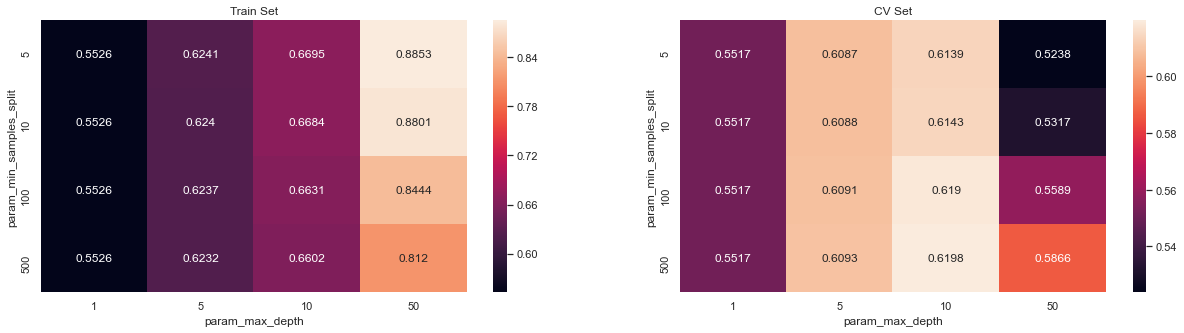

In [38]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]

plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,2, figsize=(21,5))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [39]:
max_scores1

mean_test_score                                \
param_max_depth                      1         5         10        50   
param_min_samples_split                                                 
5                              0.551677  0.608741  0.613892  0.523812   
10                             0.551677  0.608812  0.614307  0.531692   
100                            0.551677  0.609070  0.619004  0.558896   
500                            0.551677  0.609318  0.619790  0.586611   

                        mean_train_score                                
param_max_depth                       1         5         10        50  
param_min_samples_split                                                 
5                               0.552593  0.624089  0.669484  0.885294  
10                              0.552593  0.623990  0.668434  0.880067  
100                             0.552593  0.623718  0.663116  0.844402  
500                             0.552593  0.623163  0.660231  0.812048

In [40]:
max_scores = pd.DataFrame(clf.cv_results_)

In [41]:
print(clf.best_estimator_)
#Mean cross-validated score of the best_estimator

depth = clf.best_estimator_.max_depth
split = clf.best_estimator_.min_samples_split

auc_train = clf.score(X_tr_1,y_train)
auc_test = clf.score(X_te_1,y_test)
print(clf.score(X_tr_1,y_train))
print(clf.score(X_te_1,y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.6585692282365911
0.537767448339632


In [42]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

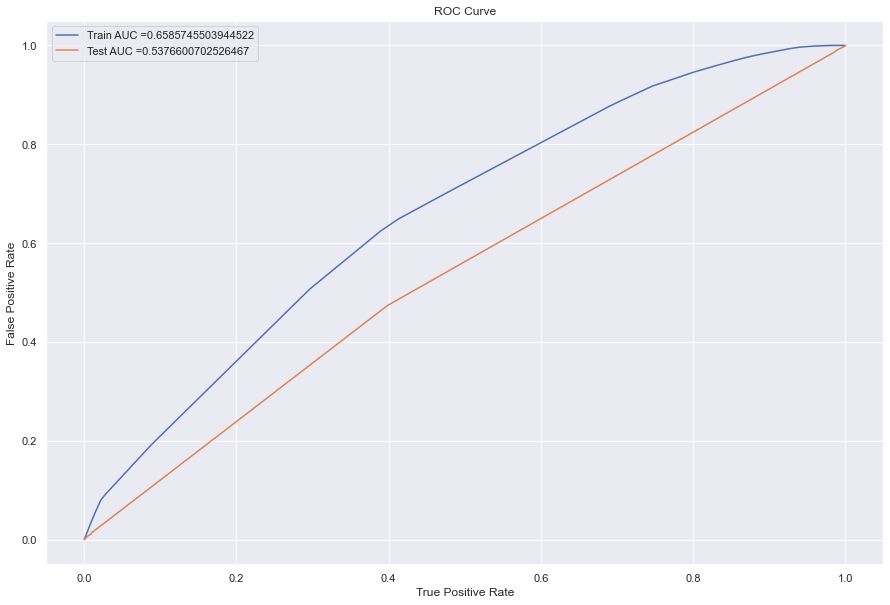

In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(max_depth = 10, min_samples_split = 500)


classifier.fit(X_tr_1, y_train)

y_train_pred = batch_predict(classifier,X_tr_1)    
y_test_pred = batch_predict(classifier,X_te_1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(15,10))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

## The confusion matrix with predicted and original labels of test data points

In [44]:
#5_Reference_SampleSolution

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [45]:
print("="*100)
print(" ")
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(" ")
print("Train confusion matrix\n")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))

train_confusion_matrix = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
train_confusion_matrix_df = pd.DataFrame(train_confusion_matrix)

print("="*100)
print(" ")
print("Test confusion matrix\n")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

pred = predict_with_best_t(y_test_pred, best_t)

test_confusion_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
test_confusion_matrix_df = pd.DataFrame(test_confusion_matrix)

 
the maximum value of tpr*(1-fpr) 0.38116028364887794 for threshold 0.876
 
Train confusion matrix

[[ 4952  3153]
 [17087 28339]]
 
Test confusion matrix

[[ 2996  1967]
 [14719 13093]]


In [46]:
print("Confusion Matrix for train test data set:\n",train_confusion_matrix_df)

Confusion Matrix for train test data set:
        0      1
0   4952   3153
1  17087  28339


In [47]:
print("Confusion Matrix for test data set:\n",test_confusion_matrix_df)

Confusion Matrix for test data set:
        0      1
0   2996   1967
1  14719  13093


### <font color='red'>Getting all the `false positive data points` , after plotting the confusion matrix with the test data

In [48]:
#reference : https://stackoverflow.com/questions/36184432/is-it-possible-to-retrieve-false-positives-false-negatives-identified-by-a-conf
false_positive_index = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (pred[i] == 1):
        false_positive_index.append(i) 
col = X_test.columns
X_test_fpd = pd.DataFrame(columns=col)
# get the data of the false pisitives
for i in false_positive_index:
    X_test_fpd = X_test_fpd.append(X_test.filter(items=[i], axis=0))
X_test_fpd.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
116,ga,mr,grades_9_12,0,math_science,mathematics,my statistical reasoning class project based c...,184.79
132,az,mrs,grades_prek_2,51,appliedlearning,charactereducation,when six years old remember sit still long per...,114.95


### <font color='red'>Plot the WordCloud with the words of `essay` text of these `false positive data points`

In [49]:
essay_fpdp = list(X_test_fpd["essay"].values)

In [50]:
np.char.lower(essay_fpdp)
corpus = " ".join(essay_fpdp)
corpus = (str(corpus)).split(" ")

In [51]:
words_fpd = []
for item in corpus:
    if item not in words_fpd:
        words_fpd.append(item)

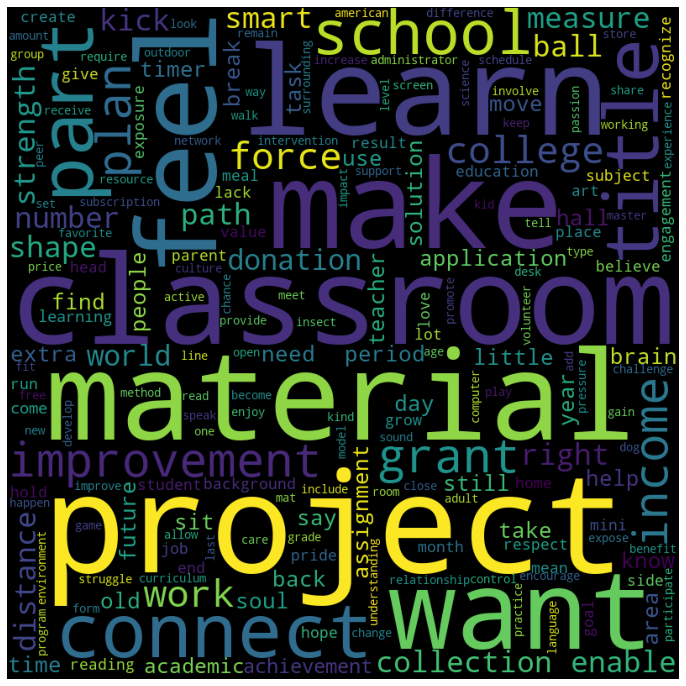

In [52]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
comment_words = ''
stopwords = set(STOPWORDS)
for word in words_fpd:
    val = str(word)
    comment_words += val+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 2) 
  
plt.show()

### <font color='red'> Plot the box plot with the `price` of these `false positive data points`

In [53]:
price_fdp = X_test_fpd["price"]

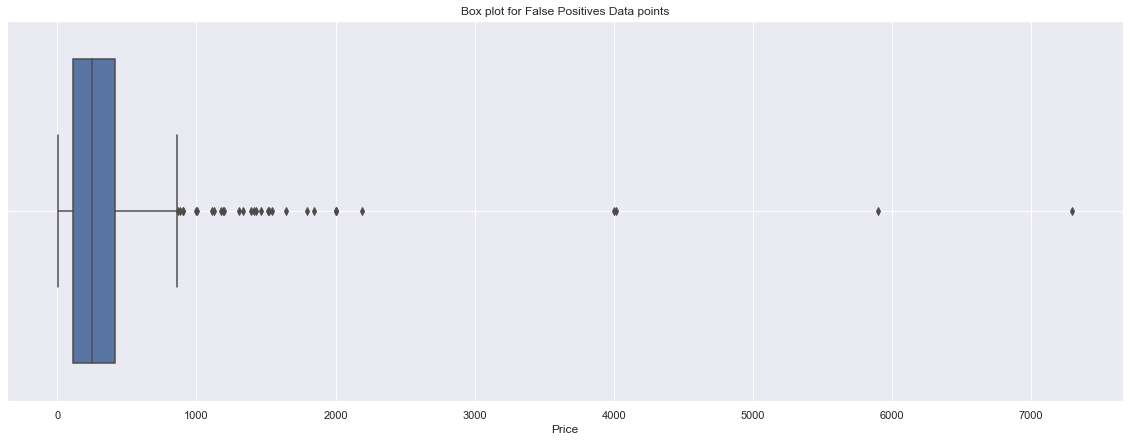

In [54]:
plt.figure(figsize=(20,7))
sns.boxplot(price_fdp)
plt.title("Box plot for False Positives Data points")
plt.xlabel("Price")
plt.grid(True)
plt.show()

### <font color='red'> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`

In [55]:
prev_project = X_test_fpd["teacher_number_of_previously_posted_projects"]

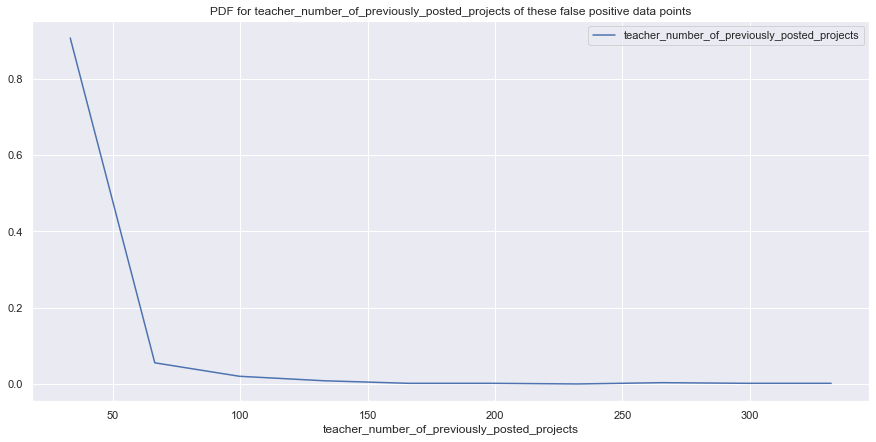

In [56]:
plt.figure(figsize=(15,7))
label = ["teacher_number_of_previously_posted_projects"]
counts, bin_edges = np.histogram(X_test_fpd["teacher_number_of_previously_posted_projects"])
pdf = counts/(sum(counts))
plt.plot(bin_edges[1:], pdf)
plt.title('PDF for teacher_number_of_previously_posted_projects of these false positive data points')
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.legend(label)
plt.show()

# Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets
### Set 2: categorical, numerical features + preprocessed_eassay (TFIDF W2V)

dt_tfidf_w2v = DecisionTreeClassifier()
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
clf1 = GridSearchCV(dt_tfidf_w2v, parameters, cv = 3,scoring='roc_auc',return_train_score=True)
clf1.fit(X_tr_1, y_train)

In [57]:
dt_tfidf = DecisionTreeClassifier()
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
clf2 = GridSearchCV(dt_tfidf, parameters, cv = 3,scoring='roc_auc',return_train_score=True)

In [58]:
clf2.fit(X_tr_2, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             pre

<Figure size 1080x720 with 0 Axes>

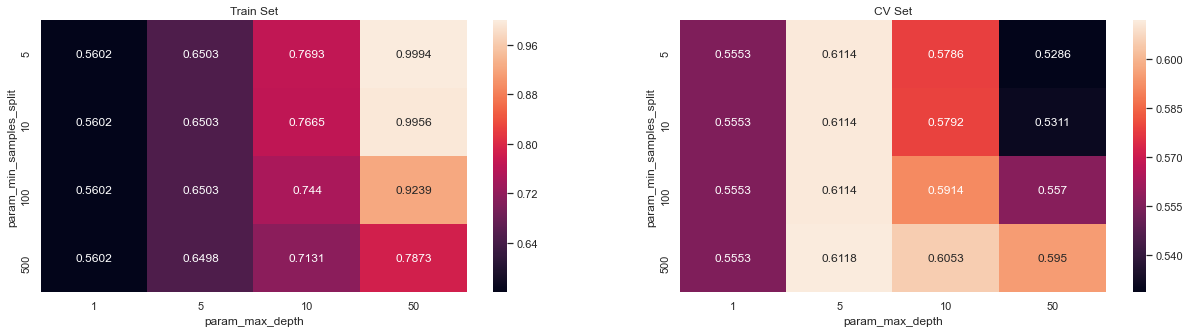

In [59]:
import seaborn as sns; sns.set()
max_scores2 = pd.DataFrame(clf2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]

plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,2, figsize=(21,5))
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [60]:
max_scores2

mean_test_score                                \
param_max_depth                      1         5         10        50   
param_min_samples_split                                                 
5                              0.555263  0.611364  0.578631  0.528626   
10                             0.555263  0.611364  0.579243  0.531053   
100                            0.555263  0.611366  0.591448  0.556950   
500                            0.555263  0.611759  0.605261  0.594974   

                        mean_train_score                                
param_max_depth                       1         5         10        50  
param_min_samples_split                                                 
5                               0.560242  0.650291  0.769334  0.999390  
10                              0.560242  0.650280  0.766540  0.995582  
100                             0.560242  0.650275  0.743954  0.923852  
500                             0.560242  0.649801  0.713137  0.787253

In [61]:
print(clf2.best_estimator_)
#Mean cross-validated score of the best_estimator

depth1 = clf2.best_estimator_.max_depth
split1 = clf2.best_estimator_.min_samples_split

auc_train1 = clf2.score(X_tr_2,y_train)
auc_test1 = clf2.score(X_te_2,y_test)
print(clf2.score(X_tr_2,y_train))
print(clf2.score(X_te_2,y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.6469877876643979
0.6089562510890673


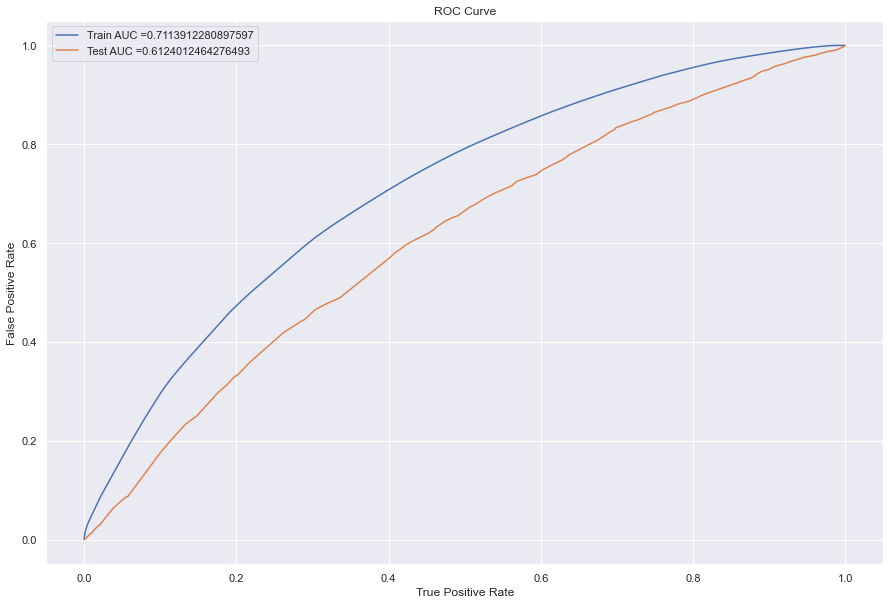

In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

classifier1 = DecisionTreeClassifier(max_depth = 10, min_samples_split = 500)


classifier1.fit(X_tr_2, y_train)

y_train_pred1 = batch_predict(classifier1,X_tr_2)    
y_test_pred1 = batch_predict(classifier1,X_te_2)

train_fpr1, train_tpr1, tr_thresholds1 = roc_curve(y_train, y_train_pred1)
test_fpr1, test_tpr1, te_thresholds1 = roc_curve(y_test, y_test_pred1)

plt.figure(figsize=(15,10))
plt.plot(train_fpr1, train_tpr1, label="Train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="Test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

In [63]:
print("="*100)
print(" ")
from sklearn.metrics import confusion_matrix
best_t1 = find_best_threshold(tr_thresholds1, train_fpr1, train_tpr1)
print(" ")
print("Train confusion matrix\n")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t1)))

train_confusion_matrix1 = confusion_matrix(y_train, predict_with_best_t(y_train_pred1, best_t1))
train_confusion_matrix_df1 = pd.DataFrame(train_confusion_matrix1)

print("="*100)
print(" ")
print("Test confusion matrix\n")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred1, best_t1)))

pred1 = predict_with_best_t(y_test_pred1, best_t1)

test_confusion_matrix1 = confusion_matrix(y_test, predict_with_best_t(y_test_pred1, best_t1))
test_confusion_matrix_df1 = pd.DataFrame(test_confusion_matrix1)

 
the maximum value of tpr*(1-fpr) 0.4289201658123103 for threshold 0.848
 
Train confusion matrix

[[ 5353  2752]
 [15925 29501]]
 
Test confusion matrix

[[ 2669  2294]
 [10246 17566]]


In [64]:
print("Confusion Matrix for train test data set:\n",train_confusion_matrix_df1)

Confusion Matrix for train test data set:
        0      1
0   5353   2752
1  15925  29501


In [65]:
print("Confusion Matrix for test data set:\n",test_confusion_matrix_df1)

Confusion Matrix for test data set:
        0      1
0   2669   2294
1  10246  17566


### <font color='red'>Getting all the `false positive data points` , after plotting the confusion matrix with the test data

In [66]:
#reference : https://stackoverflow.com/questions/36184432/is-it-possible-to-retrieve-false-positives-false-negatives-identified-by-a-conf
false_positive_index1 = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (pred1[i] == 1):
        false_positive_index1.append(i) 
col1 = X_test.columns
X_test_fpd1 = pd.DataFrame(columns=col1)
# get the data of the false pisitives
for i in false_positive_index1:
    X_test_fpd1 = X_test_fpd1.append(X_test.filter(items=[i], axis=0))
X_test_fpd1.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
3,ga,mrs,grades_prek_2,2,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [67]:
essay_fpdp1 = list(X_test_fpd1["essay"].values)

In [68]:
np.char.lower(essay_fpdp1)
corpus1 = " ".join(essay_fpdp1)
corpus1 = (str(corpus1)).split(" ")

In [69]:
words_fpd1 = []
for item in corpus1:
    if item not in words_fpd1:
        words_fpd1.append(item)

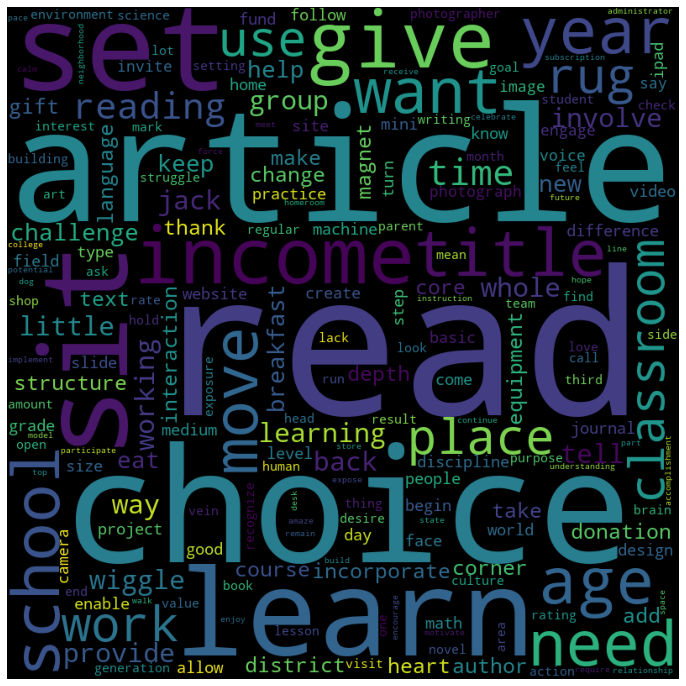

In [70]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
comment_words1 = ''
stopwords1 = set(STOPWORDS)
for word in words_fpd1:
    val = str(word)
    comment_words1 += val+" "
wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords1, 
                min_font_size = 10).generate(comment_words1)
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud1) 
plt.axis("off") 
plt.tight_layout(pad = 2) 
  
plt.show()

### <font color='red'> Plot the box plot with the `price` of these `false positive data points`

In [71]:
price_fdp1 = X_test_fpd1["price"]

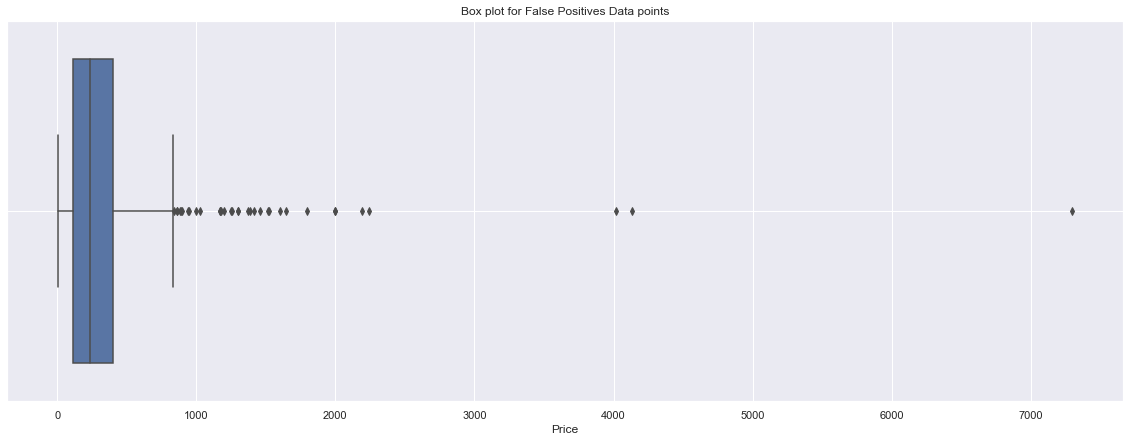

In [72]:
plt.figure(figsize=(20,7))
sns.boxplot(price_fdp1)
plt.title("Box plot for False Positives Data points")
plt.xlabel("Price")
plt.grid(True)
plt.show()

### <font color='red'> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`

In [73]:
prev_project1 = X_test_fpd1["teacher_number_of_previously_posted_projects"]

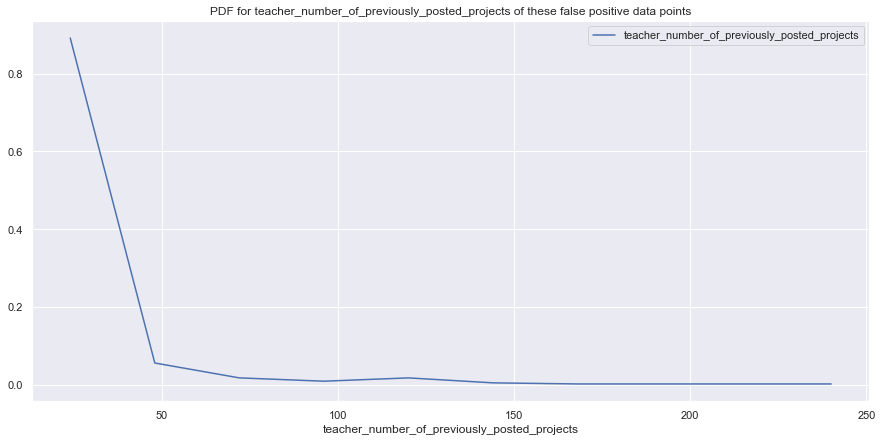

In [74]:
plt.figure(figsize=(15,7))
label = ["teacher_number_of_previously_posted_projects"]
counts1, bin_edges1 = np.histogram(X_test_fpd1["teacher_number_of_previously_posted_projects"])
pdf1 = counts1/(sum(counts1))
plt.plot(bin_edges1[1:], pdf1)
plt.title('PDF for teacher_number_of_previously_posted_projects of these false positive data points')
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.legend(label)
plt.show()

<h2>1.6 Getting top features using `feature_importances_`</h2>

## Task 2: For this task consider set-1 features. 
Select all the features which are having non-zero feature importance.
You can get the feature importance using 'feature_importances_, 
discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3

Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None. 

In [75]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

In [76]:
clf4 = DecisionTreeClassifier()
clf4.fit(X_tr_1, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [77]:
clf4.feature_importances_

array([0.00014259, 0.00040321, 0.00024425, ..., 0.        , 0.        ,
       0.00335483])

In [78]:
model = SelectFromModel(clf4, prefit=True)

In [79]:
X_new = model.transform(X_tr_1)

In [80]:
X_new_test = model.transform(X_te_1)

In [81]:
X_new_cv = model.transform(X_cr_1)

In [82]:
print(X_new.shape)
print(X_new_test.shape)
print(X_new_cv.shape)

(53531, 1452)
(32775, 1452)
(22942, 1452)


In [83]:
dt_tfidf = DecisionTreeClassifier()
parameters = {'max_depth': [1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}
clf5 = GridSearchCV(dt_tfidf, parameters, cv = 3,scoring='roc_auc',return_train_score=True)

In [84]:
clf5.fit(X_new, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500]},
             pre

<Figure size 1080x720 with 0 Axes>

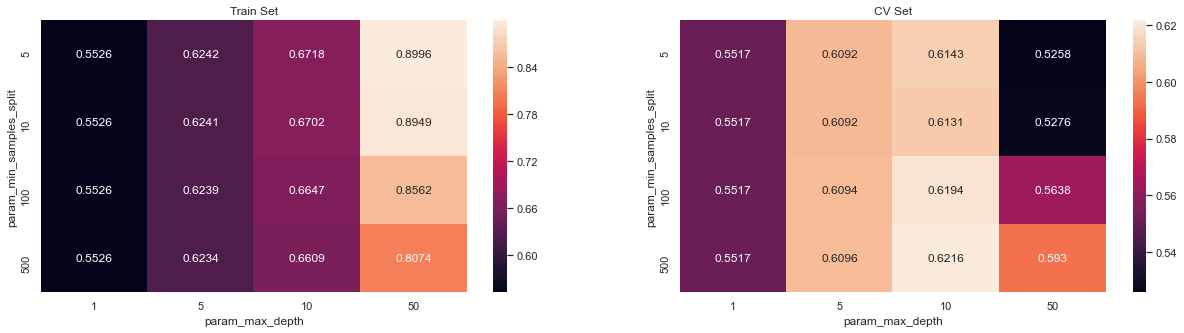

In [85]:
import seaborn as sns; sns.set()
max_scores3 = pd.DataFrame(clf5.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score','mean_train_score']]

plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,2, figsize=(21,5))
sns.heatmap(max_scores3.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores3.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [86]:
max_scores3

mean_test_score                                \
param_max_depth                      1         5         10        50   
param_min_samples_split                                                 
5                              0.551677  0.609246  0.614335  0.525831   
10                             0.551677  0.609203  0.613088  0.527569   
100                            0.551677  0.609375  0.619408  0.563814   
500                            0.551677  0.609637  0.621628  0.593014   

                        mean_train_score                                
param_max_depth                       1         5         10        50  
param_min_samples_split                                                 
5                               0.552593  0.624165  0.671778  0.899603  
10                              0.552593  0.624088  0.670170  0.894860  
100                             0.552593  0.623875  0.664697  0.856249  
500                             0.552593  0.623357  0.660866  0.807350

In [87]:
print(clf5.best_estimator_)
#Mean cross-validated score of the best_estimator

depth2 = clf5.best_estimator_.max_depth
split2 = clf5.best_estimator_.min_samples_split

auc_train2 = clf5.score(X_new,y_train)
auc_test2 = clf5.score(X_new_test,y_test)
print(clf5.score(X_new,y_train))
print(clf5.score(X_new_test,y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.6585745503944522
0.5377457647978617


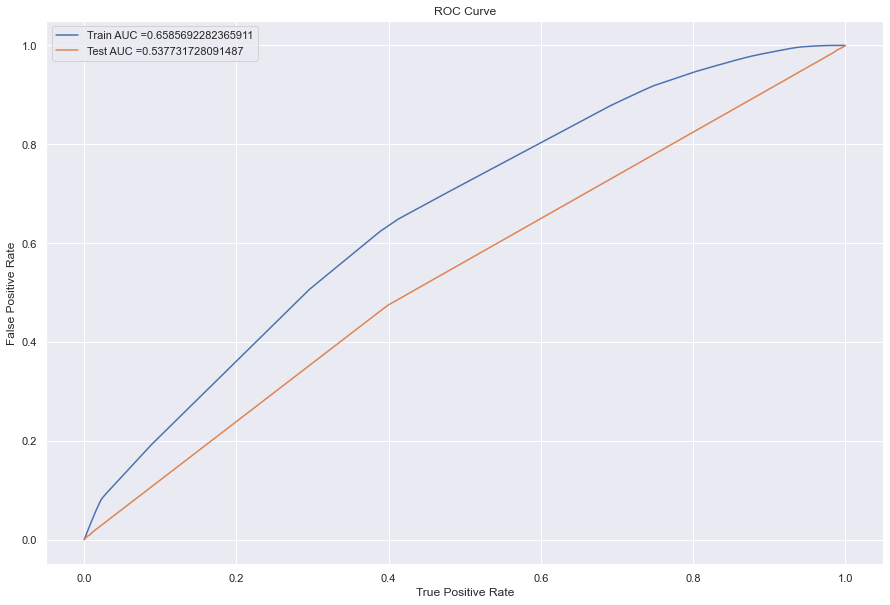

In [88]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

classifier2 = DecisionTreeClassifier(max_depth = 10, min_samples_split = 500)


classifier2.fit(X_new, y_train)

y_train_pred2 = batch_predict(classifier2,X_new)    
y_test_pred2 = batch_predict(classifier2,X_new_test)

train_fpr2, train_tpr2, tr_thresholds2 = roc_curve(y_train, y_train_pred2)
test_fpr2, test_tpr2, te_thresholds2 = roc_curve(y_test, y_test_pred2)

plt.figure(figsize=(15,10))
plt.plot(train_fpr2, train_tpr2, label="Train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="Test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

In [89]:
print("="*100)
print(" ")
from sklearn.metrics import confusion_matrix
best_t2 = find_best_threshold(tr_thresholds2, train_fpr2, train_tpr2)
print(" ")
print("Train confusion matrix\n")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred2, best_t2)))

train_confusion_matrix2 = confusion_matrix(y_train, predict_with_best_t(y_train_pred2, best_t2))
train_confusion_matrix_df2 = pd.DataFrame(train_confusion_matrix2)

print("="*100)
print(" ")
print("Test confusion matrix\n")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred2, best_t2)))

pred2 = predict_with_best_t(y_test_pred2, best_t2)

test_confusion_matrix2 = confusion_matrix(y_test, predict_with_best_t(y_test_pred2, best_t2))
test_confusion_matrix_df2 = pd.DataFrame(test_confusion_matrix2)

 
the maximum value of tpr*(1-fpr) 0.38116028364887794 for threshold 0.876
 
Train confusion matrix

[[ 4952  3153]
 [17087 28339]]
 
Test confusion matrix

[[ 2996  1967]
 [14717 13095]]


### <font color='red'>Getting all the `false positive data points` , after plotting the confusion matrix with the test data

In [90]:
#reference : https://stackoverflow.com/questions/36184432/is-it-possible-to-retrieve-false-positives-false-negatives-identified-by-a-conf
false_positive_index2 = []
for i in range (len(y_test)):
    if (y_test[i] == 0) & (pred2[i] == 1):
        false_positive_index2.append(i) 
col2 = X_test.columns
X_test_fpd2 = pd.DataFrame(columns=col2)
# get the data of the false pisitives
for i in false_positive_index2:
    X_test_fpd2 = X_test_fpd2.append(X_test.filter(items=[i], axis=0))
X_test_fpd2.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
116,ga,mr,grades_9_12,0,math_science,mathematics,my statistical reasoning class project based c...,184.79
132,az,mrs,grades_prek_2,51,appliedlearning,charactereducation,when six years old remember sit still long per...,114.95


In [91]:
essay_fpdp2 = list(X_test_fpd2["essay"].values)

In [92]:
np.char.lower(essay_fpdp1)
corpus2 = " ".join(essay_fpdp2)
corpus2 = (str(corpus2)).split(" ")

In [93]:
words_fpd2 = []
for item in corpus2:
    if item not in words_fpd2:
        words_fpd2.append(item)

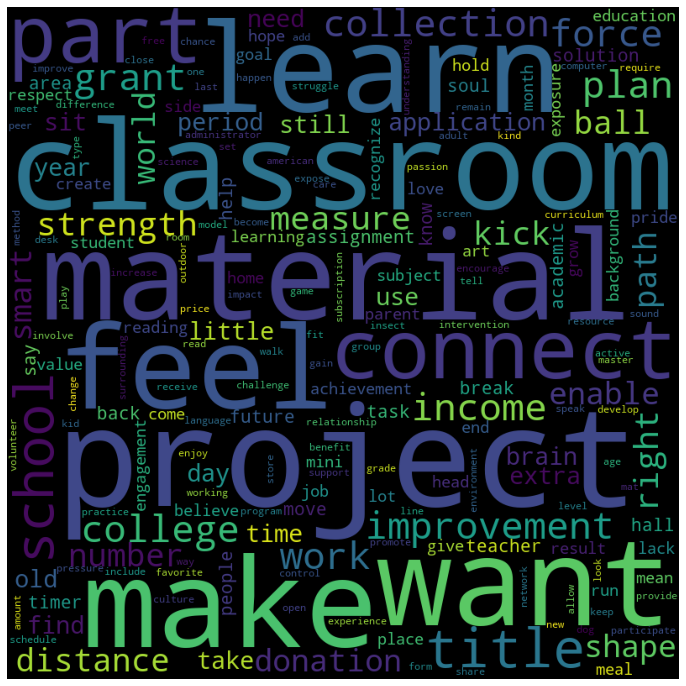

In [94]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
comment_words2 = ''
stopwords2 = set(STOPWORDS)
for word in words_fpd2:
    val = str(word)
    comment_words2 += val+" "
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords2, 
                min_font_size = 10).generate(comment_words2)
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout(pad = 2) 
  
plt.show()

### <font color='red'> Plot the box plot with the `price` of these `false positive data points`

In [95]:
price_fdp2 = X_test_fpd2["price"]

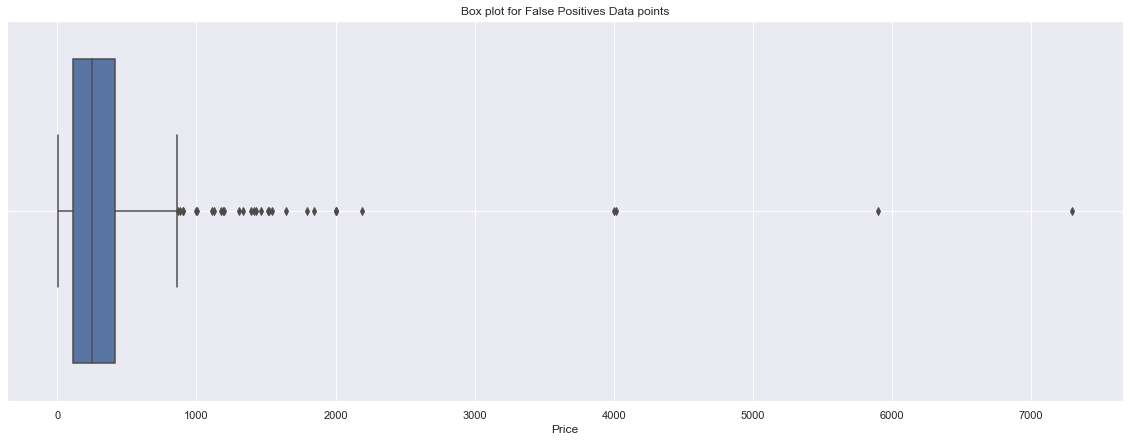

In [96]:
plt.figure(figsize=(20,7))
sns.boxplot(price_fdp2)
plt.title("Box plot for False Positives Data points")
plt.xlabel("Price")
plt.grid(True)
plt.show()

### <font color='red'> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`

In [97]:
prev_project2 = X_test_fpd2["teacher_number_of_previously_posted_projects"]

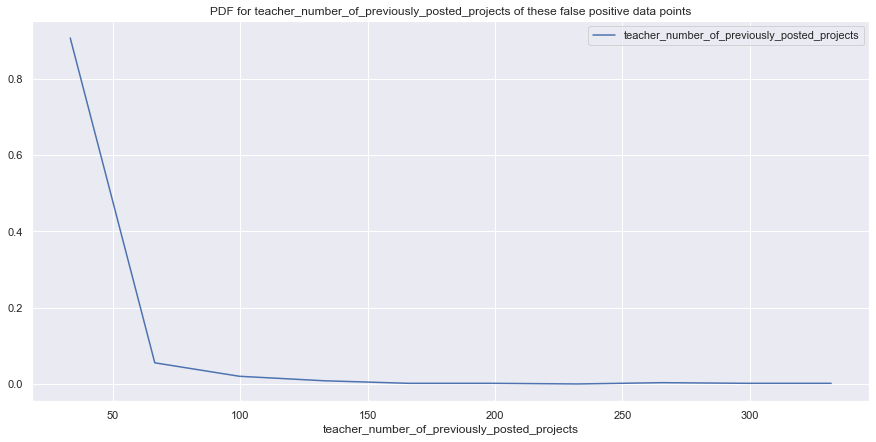

In [98]:
plt.figure(figsize=(15,7))
label = ["teacher_number_of_previously_posted_projects"]
counts2, bin_edges2 = np.histogram(X_test_fpd2["teacher_number_of_previously_posted_projects"])
pdf2 = counts2/(sum(counts2))
plt.plot(bin_edges2[1:], pdf2)
plt.title('PDF for teacher_number_of_previously_posted_projects of these false positive data points')
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.legend(label)
plt.show()

<h1>2. Summary</h1>

In [104]:
from prettytable import PrettyTable

summary = PrettyTable()

summary.field_names = ["Vectorizer", "Hyperparameter", "Train_AUC", "Test-AUC"]

summary.add_row(["TFIDF","Depth: " +str(depth)+" | Sample Split: "+str(split)  , round(auc_train,3),round(auc_test,3)])
summary.add_row(["TFIDFW2V","Depth: " +str(depth1)+" | Sample Split: "+str(split1) , round(auc_train1,3),round(auc_test1,3)])
summary.add_row(["TFIDF non-zero feature importance","Depth: " +str(depth2)+" | Sample Split: "+str(split2)  , round(auc_train2,3),round(auc_test2,3)])

print(summary)

+-----------------------------------+-------------------------------+-----------+----------+
|             Vectorizer            |         Hyperparameter        | Train_AUC | Test-AUC |
+-----------------------------------+-------------------------------+-----------+----------+
|               TFIDF               | Depth: 10 | Sample Split: 500 |   0.659   |  0.538   |
|              TFIDFW2V             |  Depth: 5 | Sample Split: 500 |   0.647   |  0.609   |
| TFIDF non-zero feature importance | Depth: 10 | Sample Split: 500 |   0.659   |  0.538   |
+-----------------------------------+-------------------------------+-----------+----------+
